# Time Series Clustering with Topological Data Analysis

_Created by:_ Philipp Weiler and Lewis Tunstall, December 2019.

_Blog post:_ ADD BLOG POST LINK HERE


This notebook explores the application of topological data analysis (TDA) for time series clustering. We partially follow ideas presented in a paper by <a href="https://www.sciencedirect.com/science/article/pii/S0957417415002407">Pereira and de Mello</a> in  2015.
The TDA features are extracted with the help of <a href="https://giotto.ai">gitto-learn</a>, an open-source Python library designed for integrating TDA within the <a href="https://scikit-learn.org/stable/sklearn">scikit-learn</a> framework.

## Beetle dynamics
Here we aim to cluster two different time series that describe the population of the [_Tribolium_ flour beetle](https://en.wikipedia.org/wiki/Red_flour_beetle). The beetle's life cycle consists of larva, pupa, and adult stages, with the transition between each stage lasting two weeks.  Following <a href="https://www.nature.com/articles/375227a0">Costantino, Cushing, Dennis and Desharnais</a>, we can describe the dynamics of the beetle population using the following difference equation:

$$
\begin{equation}
    \begin{aligned}
        L_{t + 1} &= b A_t e^{E_{1, t} -c_{ea} A_t - c_{el} L_t}\\
        P_{t + 1} &= L_t (1 - \mu_l) e^{E_{2, t}}\\
        A_{t + 1} &= [P_t e^{-c_{pa} A_t} + A_t (1 - \mu_a)]e^{E_{3, t}}
    \end{aligned}
    \tag{1}
    \label{eq: BeetleEq}
\end{equation}
$$

Here $L_t, P_t$ and $A_t$ denote the number of larvae, pupae and adults at time $t$, while $\mu_l$ and $\mu_a$ denote the fraction of larvae and pupae that dies. _Tribolium_ flour beetles become cold-hearted in face of overpopulation as they turn cannibalistic by eating unhatched eggs and pupae. This behaviour was modeled probabilistcally with the terms $exp(-c_{ea}A_t)$ and $exp(-c_{el}L_t)$. The probability of surviving this massacre from pupa to adult stage is given by $exp(-c_{pa}A_t)$. To incorporate for example environmental uncertainty, we include multivariate normally distributed noise $E_{1, t}, E_{2, t}$ and $E_{3, t}$ with mean zero and common standard deviation $\sigma$.

# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
# data wrangling
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

# tda magic
import giotto as gt
import giotto.time_series as ts
import giotto.homology as hl
from giotto.pipeline import Pipeline
from utils import get_amplitude, get_max_lifetime, get_mean_lifetime, get_n_rel_holes

# data viz
from utils import plot_diagram
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# ml tools
from sklearn.model_selection import train_test_split
from utils import fit_and_score_model
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import homogeneity_score

# Generate and load data
In the `generate_data.py` script we have implemented the dynamical equations describing the evolution of the _Tribolium_ flour beetle population. Each time step corresponds to two weeks and depending on the chosen values for $b, c_{ea}, c_{el}, c_{pa}, \mu_l$, and $\mu_a$ the system is driven towards either a _**stable steady state**_ or _**aperiodic behavior**_.

By running the script below, we simulate the population dynamics for 120 time steps overall 200 times for both the stable as well as aperiodic behavior. For each time series, the initial state of the system is instantiated with integers drawn randomly from the interval $[2, 100]$; the noise is generated at random as well.

In [3]:
# config parameters
n_steps = 120
n_series = 200

In [4]:
%run generate_data.py --n_steps {n_steps} --n_series {n_series}

In [5]:
DATA = Path('data/')
!ls {DATA}

population_data.pkl


In [6]:
data = pd.read_pickle(DATA/'population_data.pkl'); data.head()

,larvae,pupae,adults,series_id,type
0,38.704932,95.170002,73.735406,0,stable
1,178.307125,28.154191,90.162099,0,stable
2,35.280726,129.115862,42.528425,0,stable
3,141.913491,26.140749,118.076790,0,stable
4,55.611714,103.009010,47.749613,0,stable


In [7]:
data.shape

(48400, 5)

# Explore the data
By construction we generate an equal quantity of stable and aperiodic time series; let's check that this is indeed the case:

In [8]:
data['type'].value_counts()

aperiodic    24200
stable       24200
Name: type, dtype: int64

Next let us visually compare how the different behaviours are exhbited in the time series:

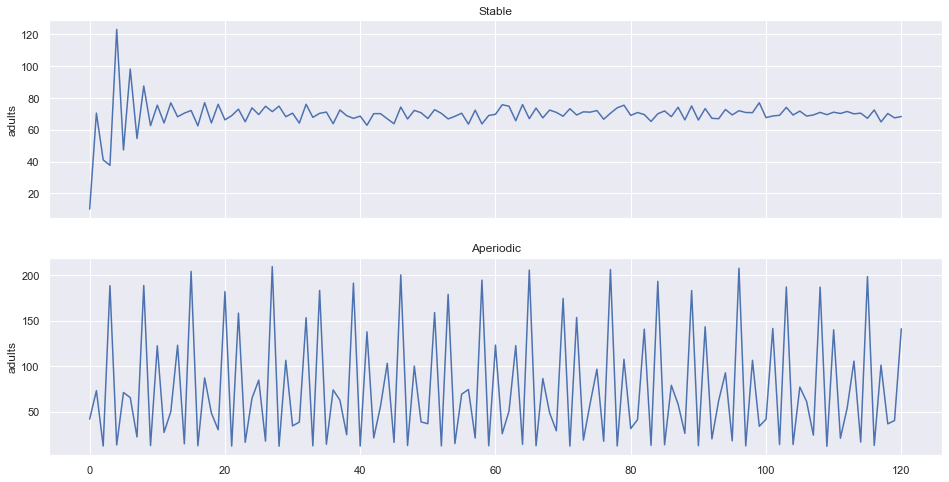

In [9]:
# tweak the ID to compare different times series pairs
series_id = 42

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))

sns.lineplot(
    x=range(n_steps + 1),
    y=data[(data["series_id"] == series_id) & (data["type"] == "stable")]["adults"],
    ax=ax[0],
).set_title("Stable")

sns.lineplot(
    x=range(n_steps + 1),
    y=data[(data["series_id"] == series_id) & (data["type"] == "aperiodic")]["adults"],
    ax=ax[1],
).set_title("Aperiodic")

plt.show()

Evidently there is a clear visual difference between the stable and aperiodic behaviours - let's see if we can cluster the time series using TDA features with traditional clustering algorithms!

# Clustering

## Generate labels

First we generate the labels for the two different time series ($1$ for aperiodic, $0$ for stable) and split the data into train and test set.

In [10]:
y_true = np.repeat([1, 0], n_series)

id_train, id_test, y_train, y_test = train_test_split(
    range(2 * n_series), y_true, train_size=0.7, random_state=0
)

## Naive approach

As a simple baseline, we take the raw time series data describing the adult popultation of _Tribolium_ flour beetle and use <a href="https://scikit-learn.org/stable/modules/clustering.html#k-means">k-means</a> to cluster it. To measure the performance, we calculate the [homogeneity score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html). This score is useful to check whether the clusters only samples belonging to a single class and takes values in the range [0,1], where low values indicate low homogeneity.

In [41]:
X_naive = data["adults"].values.reshape((2 * n_series, -1))
fit_and_score_model(X_naive, y_train, y_test, id_train, id_test)

Homogeneity score (training): 0.42029944862990926
Homogeneity score (test): 0.43107891041790375


As we can see from the scores, using only the raw time series does not provide a satisfying clustering. Let's turn to TDA next to try to improve the performance!

## TDA Approach

As explained in the accompanying blog post, applying TDA to time series involves several steps that are summarised here:

1. Embed the time series using <a href="https://docs.giotto.ai/generated/giotto.time_series.TakensEmbedding.html#giotto.time_series.TakensEmbedding">Takens' embedding</a> into a higher dimensional space. 
2. Use the <a href="https://docs.giotto.ai/generated/giotto.homology.VietorisRipsPersistence.html#giotto.homology.VietorisRipsPersistence">Vietoris-Rips filtration</a> to calculate the persistence diagrams.
3. Scale and filter the diagrams.

These steps can be conveniently combined via the `Pipeline` [class](https://docs.giotto.ai/generated/giotto.pipeline.Pipeline.html#giotto.pipeline.Pipeline) from `giotto-learn`.

### Configuration parameters for pipeline

In [15]:
parameters_type = "fixed"
embedding_dimension = 2
embedding_time_delay = 3
n_jobs = 1

window_width = X.shape[0] - ((embedding_dimension - 1) * embedding_time_delay + 1)
window_stride = 1

metric = "euclidean"
max_edge_length = 10
homology_dimensions = [0, 1]

epsilon = 0.0

### Define pipeline

In [19]:
steps = [
    (
        "embedding",
        ts.TakensEmbedding(
            parameters_type=parameters_type,
            dimension=embedding_dimension,
            time_delay=embedding_time_delay,
            n_jobs=n_jobs,
        ),
    ),
    ("window", ts.SlidingWindow(width=window_width, stride=1)),
    (
        "diagrams",
        hl.VietorisRipsPersistence(
            metric=metric,
            max_edge_length=max_edge_length,
            homology_dimensions=homology_dimensions,
            n_jobs=n_jobs,
        ),
    ),
    ("diagrams_scaler", diag.Scaler()),
    ("diagrams_filter", diag.Filtering(epsilon=epsilon)),
]

pipeline = Pipeline(steps)

### Run pipeline

In [21]:
grouped_data = data.groupby(['type', 'series_id'])

X_filtered = []
for name, _ in tqdm(grouped_data):
    X_filtered.append(
        pipeline.fit_transform(grouped_data.get_group(name)["adults"].values)
    )

100%|██████████| 400/400 [00:02<00:00, 168.92it/s]


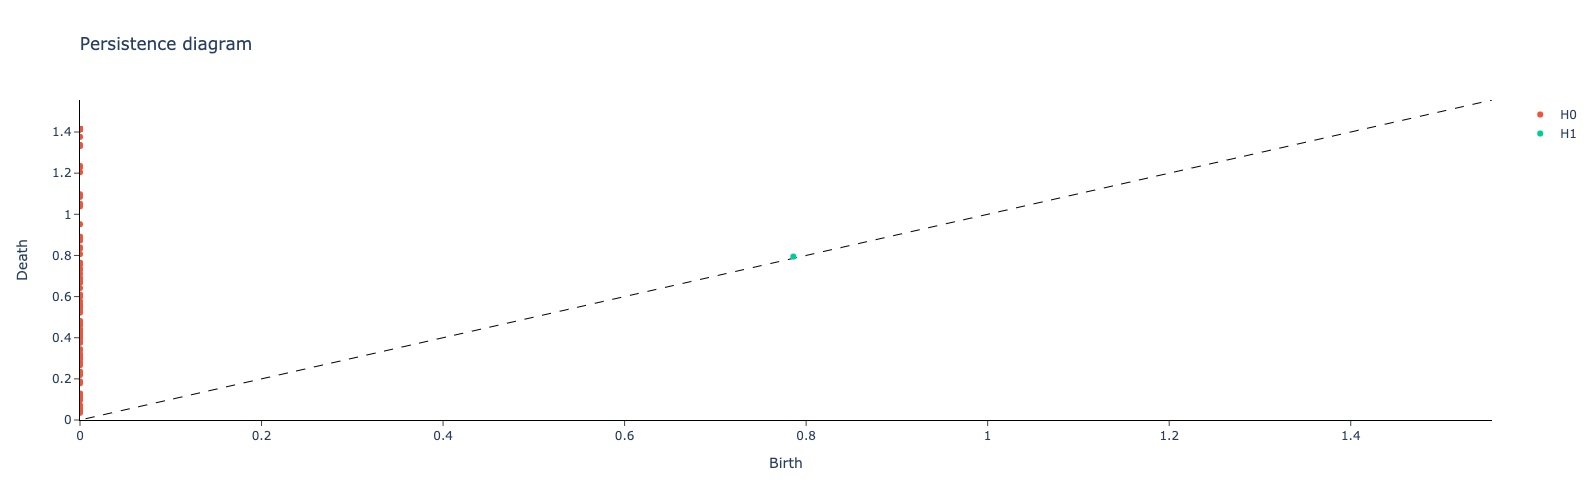

In [30]:
# plot the persistence diagram
plot_diagram(X_filtered[0][0])

### Functions for Feature Creation

Looking at persistence diagrams of our two cases, we see some differences. To capture these, we decide to calculate:
1. The mean lifetime of the holes per dimension
2. The number of holes per dimension
3. The number of holes that "survive" longer than a given threshold. We choose it as a fraction of the maximum lifetime of holes in the dimension,
4. The maximum lifetime of the holes per dimension
5. The amplitude of the diagram

We have implemented these functions in `utils.py` to extract these features from the persistence diagram.

### Parameters for TDA Features

We run the pipeline for each time series and create the corresponding features

In [36]:
# threshold to determine whether a hole is relevant or not
frac = 0.7

### TDA Feature Creation

In [37]:
features = []
for name, _ in tqdm(grouped_data):
    X_filtered = pipeline.fit_transform(grouped_data.get_group(name)["adults"].values)
    n_windows, n_points, _ = X_filtered.shape

    features.append(
        get_mean_lifetime(X_filtered, n_windows, n_points)
        + get_n_rel_holes(X_filtered, n_windows, n_points, frac=frac)
        + get_n_rel_holes(X_filtered, n_windows, n_points, frac=0.0)
        + get_max_lifetime(X_filtered, n_windows, n_points)
        + get_amplitude(X_filtered)
    )

100%|██████████| 400/400 [00:14<00:00, 28.09it/s]


### Clustering

Finally we perform clustering with the TDA features and calculate the homogeneity scores:

In [44]:
X_tda = np.array(features)
fit_and_score_model(X_tda, y_train, y_test, id_train, id_test)

Homogeneity score (training): 0.9692483881602528
Homogeneity score (test): 0.9391555049212249


## Performance vs. Noise

__Step 7:__ Next, we want to check how the performance changes when increase the noise.

In [36]:
def simu_data(noise):
    # instantiate instances of beetle class
    pop_stable = BeetlePopulation(**args_stable)
    pop_aperiodic = BeetlePopulation(**args_aperiodic)

    # Define data frame for simulated data. The columns contain
    # the number of current larvae, pupae and adults.
    data = pd.DataFrame(columns=['larvae', 'pupae', 'adults'])

    # simulate stable case
    for itr in range(n_series):
        l_0, p_0, a_0 = 98 * np.random.rand(3) + 2
        
        std_noise = 0.1 * np.random.randn(3) + noise

        data = pd.concat([data,
                          pop_stable.simulate(l_0=l_0,
                                              p_0=p_0,
                                              a_0=a_0,
                                              std_noise=std_noise,
                                              n_steps=n_steps)])

    # simulate aperiodic case
    for itr in range(n_series):
        l_0, p_0, a_0 = 98 * np.random.rand(3) + 2
        std_noise = 0.1 * np.random.randn(3) + noise
        data = pd.concat([data,
                          pop_aperiodic.simulate(l_0=l_0,
                                                 p_0=p_0,
                                                 a_0=a_0,
                                                 std_noise=std_noise,
                                                 n_steps=n_steps)])

    # add an id for each time series (the id is only unique within a case)
    data['series_id'] = 2 * sorted((n_steps + 1) * list(range(n_series)))
    # add a label of the time series indicated the case it belongs to,
    # i.e. either stable or aperiodic
    data['type'] = n_series * (n_steps + 1) * ['stable'] +\
        n_series * (n_steps + 1) * ['aperiodic']

    return data

In [37]:
# noise parameters
min_noise = 0.
max_noise = 2.1
step_size = 0.1

# maximal number of repetitions per noise level (for confidence intervals)
max_itr = 5

# data frames to save performance
perf_train = pd.DataFrame(columns={'Score', 'Type', 'Mean Standard Deviation of Noise'})
perf_test = pd.DataFrame(columns={'Score', 'Type', 'Mean Standard Deviation of Noise'})

for noise in tqdm(np.arange(min_noise, max_noise, step_size)):
    for _ in range(max_itr):
        data = simu_data(noise)
        # group data by type and series id
        grouped_data = data.groupby(['type', 'series_id'])

        y_true = np.repeat([1, 0], n_series)
        id_train, id_test,\
            y_train, y_test = train_test_split(range(2 * n_series),
                                               y_true, train_size=0.7,
                                               random_state=0)


        # classical k-means ###########################################################
        X = data['adults'].values.reshape((2 * n_series, -1))
        # train/test data
        X_train = X[id_train, :]
        X_test = X[id_test, :]

        # k means
        kmeans = KMeans(n_clusters=2, random_state=0)
        kmeans.fit(X_train)

        perf_train = perf_train.append({'Score': homogeneity_score(y_train,
                                                                   kmeans.labels_),
                                        'Type': 'Classic',
                                        'Mean Standard Deviation of Noise': noise},
                                       ignore_index=True)

        perf_test = perf_test.append({'Score': homogeneity_score(y_test,
                                                                 kmeans.predict(X_test)),
                                      'Type': 'Classic',
                                      'Mean Standard Deviation of Noise': noise},
                                     ignore_index=True)


        # TDA k-means
        features = []
        for name, _ in grouped_data:
            X_filtered = pipeline.fit_transform(grouped_data.get_group(name)['adults'].values)
            n_windows, n_points, _ = X_filtered.shape
            features.append(get_mean_lifetime(X_filtered, n_windows, n_points) +
                            get_n_rel_holes(X_filtered, n_windows, n_points, frac=frac) +
                            get_n_rel_holes(X_filtered, n_windows, n_points, frac=0.) +
                            get_max_lifetime(X_filtered, n_windows, n_points) +
                            get_amplitude(X_filtered))

        # define data matrix for k-means
        X_tda = np.array(features)

        X_tda_train = X_tda[id_train, :]
        X_tda_test = X_tda[id_test, :]

        # k means
        kmeans_tda = KMeans(n_clusters=2, random_state=0)
        kmeans_tda.fit(X_tda_train)

        perf_train = perf_train.append({'Score': homogeneity_score(y_train,
                                                                   kmeans_tda.labels_),
                                        'Type': 'TDA',
                                        'Mean Standard Deviation of Noise': noise},
                                       ignore_index=True)

        perf_test = perf_test.append({'Score': homogeneity_score(y_test,
                                                                 kmeans_tda.predict(X_tda_test)),
                                      'Type': 'TDA',
                                      'Mean Standard Deviation of Noise': noise},
                                     ignore_index=True)

100%|██████████| 21/21 [21:52<00:00, 62.50s/it]


We see, that the TDA approach outperforms the naive one. The performance of both approaches begins to decresase in the beginning. While the naive approach completely fails to cluster the data for mean standard deviations larger than $0.4$. The performance of the TDA approach, however, increases again. When we plot the data with high noise, the reason becomes obvious, as the two time series differ again from one and another. The main difference is the magnitude of the signal.

In [40]:
with open('models/performance_metrics_train.pkl', 'wb') as file:
    pickle.dump(perf_train, file)

In [41]:
with open('models/performance_metrics_test.pkl', 'wb') as file:
    pickle.dump(perf_test, file)

Text(0.5, 1.0, 'Homogeneity Score - Testing')

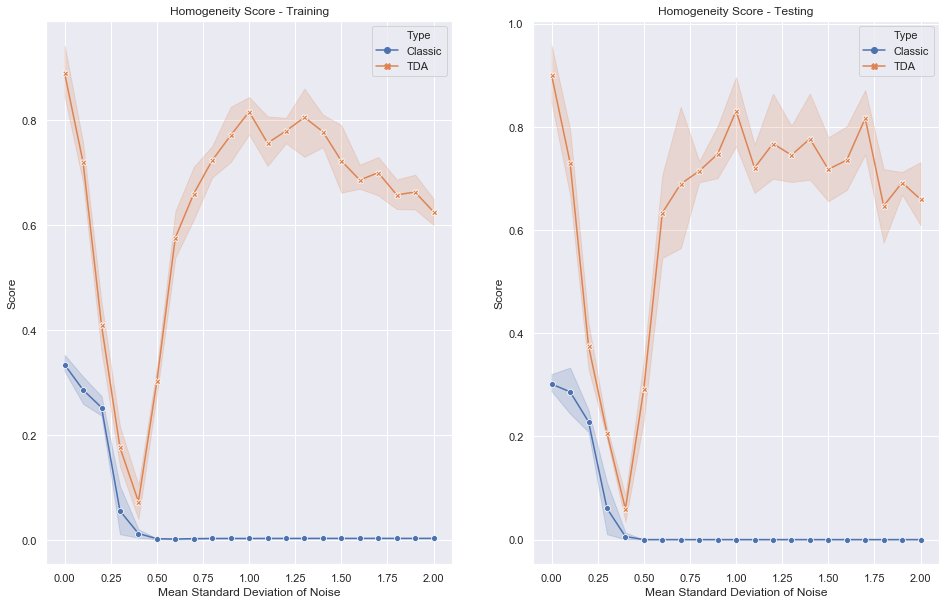

In [39]:
f, ax = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(16)
(sns.lineplot(x='Mean Standard Deviation of Noise', y='Score', hue='Type', style='Type',
              markers=True, dashes=False, data=perf_train, ax=ax[0])
 .set_title('Homogeneity Score - Training'))
(sns.lineplot(x='Mean Standard Deviation of Noise', y='Score', hue='Type', style='Type',
              markers=True, dashes=False, data=perf_test, ax=ax[1])
 .set_title('Homogeneity Score - Testing'))

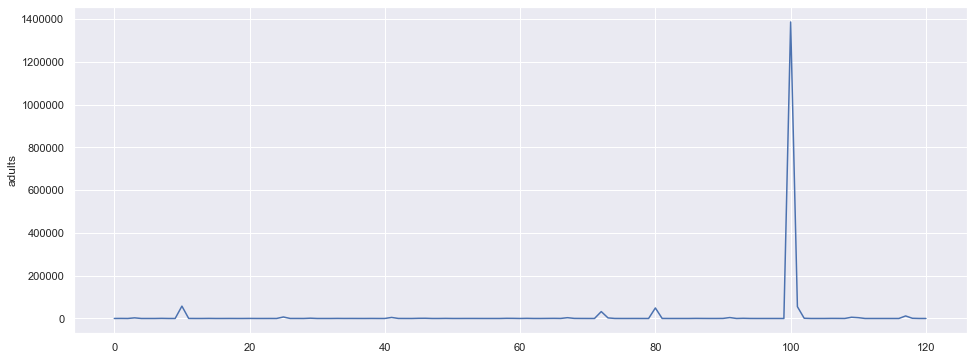

In [26]:
# plot the aperiodic example here
plt.figure(figsize=(16, 6))
sns.lineplot(x=range(n_steps + 1),
             y=data[(data['series_id'] == 0) &
                    (data['type'] == 'aperiodic')]['adults'])

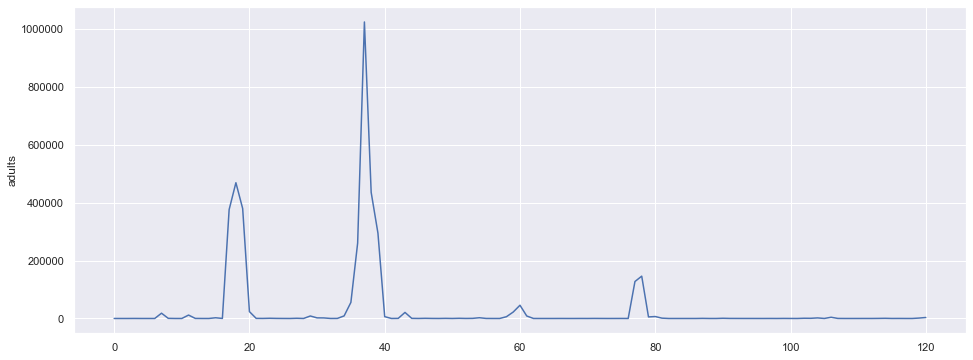

In [27]:
# plot the stable example here
plt.figure(figsize=(16, 6))
sns.lineplot(x=range(n_steps + 1),
             y=data[(data['series_id'] == 0) &
                    (data['type'] == 'stable')]['adults'])

Let's have a closer look at the performance of the two approaches for smaller mean standard deviations.

In [28]:
# noise parameters
min_noise = 0.
max_noise = 0.401
step_size = 0.05

# maximal number of repetitions per noise level (for confidence intervals)
max_itr = 5

# data frames to save performance
perf_train = pd.DataFrame(columns={'Score', 'Type', 'Mean Standard Deviation of Noise'})
perf_test = pd.DataFrame(columns={'Score', 'Type', 'Mean Standard Deviation of Noise'})

for noise in tqdm(np.arange(min_noise, max_noise, step_size)):
    for _ in range(max_itr):
        data = simu_data(noise)
        # group data by type and series id
        grouped_data = data.groupby(['type', 'series_id'])

        y_true = np.repeat([1, 0], n_series)
        id_train, id_test,\
            y_train, y_test = train_test_split(range(2 * n_series),
                                               y_true, train_size=0.7,
                                               random_state=0)


        # classical k-means ###########################################################
        X = data['adults'].values.reshape((2 * n_series, -1))
        # train/test data
        X_train = X[id_train, :]
        X_test = X[id_test, :]

        # k means
        kmeans = KMeans(n_clusters=2, random_state=0)
        kmeans.fit(X_train)

        perf_train = perf_train.append({'Score': homogeneity_score(y_train,
                                                                   kmeans.labels_),
                                        'Type': 'Classic',
                                        'Mean Standard Deviation of Noise': noise},
                                       ignore_index=True)

        perf_test = perf_test.append({'Score': homogeneity_score(y_test,
                                                                 kmeans.predict(X_test)),
                                      'Type': 'Classic',
                                      'Mean Standard Deviation of Noise': noise},
                                     ignore_index=True)


        # TDA k-means
        features = []
        for name, _ in grouped_data:
            X_filtered = pipeline.fit_transform(grouped_data.get_group(name)['adults'].values)
            n_windows, n_points, _ = X_filtered.shape
            features.append(get_mean_lifetime(X_filtered, n_windows, n_points) +
                            get_n_rel_holes(X_filtered, n_windows, n_points, frac=frac) +
                            get_n_rel_holes(X_filtered, n_windows, n_points, frac=0.) +
                            get_max_lifetime(X_filtered, n_windows, n_points) +
                            get_amplitude(X_filtered))

        # define data matrix for k-means
        X_tda = np.array(features)

        X_tda_train = X_tda[id_train, :]
        X_tda_test = X_tda[id_test, :]

        # k means
        kmeans_tda = KMeans(n_clusters=2, random_state=0)
        kmeans_tda.fit(X_tda_train)

        perf_train = perf_train.append({'Score': homogeneity_score(y_train,
                                                                   kmeans_tda.labels_),
                                        'Type': 'TDA',
                                        'Mean Standard Deviation of Noise': noise},
                                       ignore_index=True)

        perf_test = perf_test.append({'Score': homogeneity_score(y_test,
                                                                 kmeans_tda.predict(X_tda_test)),
                                      'Type': 'TDA',
                                      'Mean Standard Deviation of Noise': noise},
                                     ignore_index=True)

100%|██████████| 9/9 [09:56<00:00, 66.33s/it]


Text(0.5, 1.0, 'Homogeneity Score - Testing')

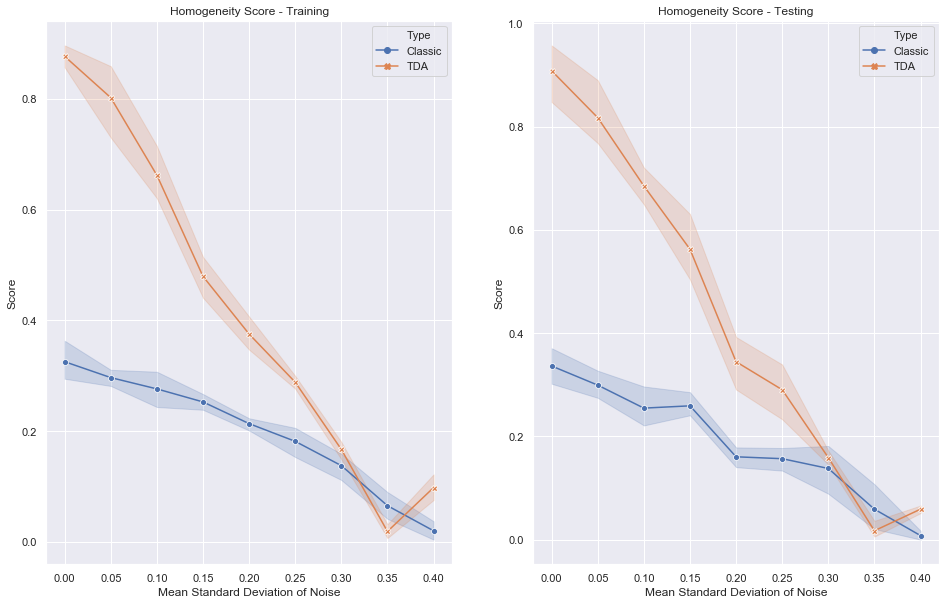

In [29]:
f, ax = plt.subplots(1, 2)
f.set_figheight(10)
f.set_figwidth(16)
(sns.lineplot(x='Mean Standard Deviation of Noise', y='Score', hue='Type', style='Type',
              markers=True, dashes=False, data=perf_train, ax=ax[0])
 .set_title('Homogeneity Score - Training'))
(sns.lineplot(x='Mean Standard Deviation of Noise', y='Score', hue='Type', style='Type',
              markers=True, dashes=False, data=perf_test, ax=ax[1])
 .set_title('Homogeneity Score - Testing'))

## Results

We have seen that clustering the time series with the help of TDA features generated from these yields better results than simply using the raw data. In addition, we saw that the performance is still better if we increase the noise added to the model.